<a href="https://colab.research.google.com/github/ReJackTion/cat-dog-image-classification/blob/main/Cat_Dog_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get the datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore') #ignore warning to imporve readability

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rejacktion","key":"d220aa203f222a910326083ae50ae9b8"}'}

In [ ]:
!mkdir ~/.kaggle #make a new folder
!cp /content/kaggle.json ~/.kaggle/ #copy file to that folder
!chmod 600 ~/.kaggle/kaggle.json #to allow read and write the file

In [ ]:
!kaggle datasets download -d erkamk/cat-and-dog-images-dataset

 91% 116M/128M [00:02<00:00, 69.2MB/s] 
100% 128M/128M [00:02<00:00, 56.5MB/s]


In [ ]:
!unzip cat-and-dog-images-dataset.zip

Archive:  cat-and-dog-images-dataset.zip
  inflating: Dog and Cat .png/Cat/1.png  
  inflating: Dog and Cat .png/Cat/10.png  
  inflating: Dog and Cat .png/Cat/100.png  
  inflating: Dog and Cat .png/Cat/101.png  
  inflating: Dog and Cat .png/Cat/102.png  
  inflating: Dog and Cat .png/Cat/103.png  
  inflating: Dog and Cat .png/Cat/104.png  
  inflating: Dog and Cat .png/Cat/105.png  
  inflating: Dog and Cat .png/Cat/106.png  
  inflating: Dog and Cat .png/Cat/107.png  
  inflating: Dog and Cat .png/Cat/108.png  
  inflating: Dog and Cat .png/Cat/109.png  
  inflating: Dog and Cat .png/Cat/11.png  
  inflating: Dog and Cat .png/Cat/110.png  
  inflating: Dog and Cat .png/Cat/111.png  
  inflating: Dog and Cat .png/Cat/112.png  
  inflating: Dog and Cat .png/Cat/113.png  
  inflating: Dog and Cat .png/Cat/114.png  
  inflating: Dog and Cat .png/Cat/115.png  
  inflating: Dog and Cat .png/Cat/116.png  
  inflating: Dog and Cat .png/Cat/117.png  
  inflating: Dog and Cat .png/Cat/118.p

# Create File DataFrame

In [ ]:
image_dir = Path('/content/Dog and Cat .png')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/content/Dog and Cat .png/Cat/139.png,Cat
1,/content/Dog and Cat .png/Cat/t83.png,Cat
2,/content/Dog and Cat .png/Cat/275.png,Cat
3,/content/Dog and Cat .png/Cat/160.png,Cat
4,/content/Dog and Cat .png/Cat/79.png,Cat
...,...,...
994,/content/Dog and Cat .png/Dog/d320.png,Dog
995,/content/Dog and Cat .png/Dog/g67.png,Dog
996,/content/Dog and Cat .png/Dog/d1.png,Dog
997,/content/Dog and Cat .png/Dog/g17.png,Dog


In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=42)

# Load Image Data

In [ ]:
'''
# Data Augmentation
train_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
    shear_range=0.2, # shear the image
    zoom_range=0.2, # zoom into the image
    width_shift_range=0.2, # shift the image width ways
    height_shift_range=0.2, # shift the image height ways
    horizontal_flip=True # flip the image on the horizontal axis
)

test_generator_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
'''

In [ ]:
# Transfer learning feature extractor
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


# Load Pretrained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


# Model Building

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 222, 222, 16)      448       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 111, 111, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 109, 109, 32)      4640      
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 54, 54, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 52, 52, 64)        18496     
_________________________________________________________________
maxpool3 (MaxPooling2D)      (None, 26, 26, 64)        0         
_________________________________________________________________
avgpool (GlobalAveragePoolin (None, 64)                0

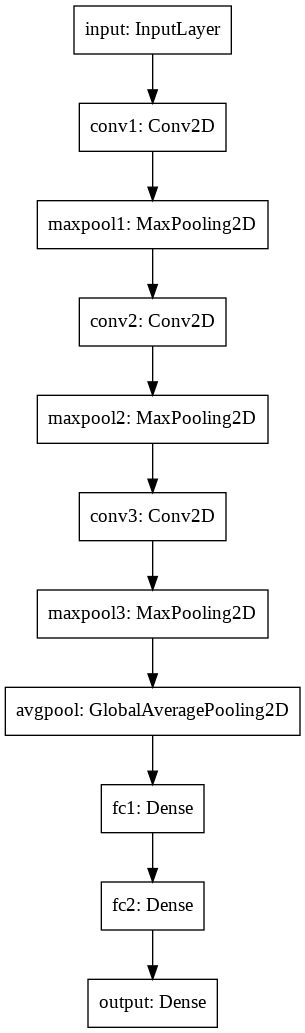

In [ ]:
'''
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(224, 224, 3), name='input'),

  tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='leaky_relu', kernel_regularizer='l2', name='conv1'),
  tf.keras.layers.MaxPool2D(name='maxpool1'),

  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='leaky_relu', kernel_regularizer='l2', name='conv2'),
  tf.keras.layers.MaxPool2D(name='maxpool2'),

  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='leaky_relu', kernel_regularizer='l2', name='conv3'),
  tf.keras.layers.MaxPool2D(name='maxpool3'),

  tf.keras.layers.GlobalAveragePooling2D(name='avgpool'),

  tf.keras.layers.Dense(128, activation='leaky_relu', kernel_regularizer='l2', name='fc1'),
  tf.keras.layers.Dense(64, activation='leaky_relu', kernel_regularizer='l2', name='fc2'),

  tf.keras.layers.Dense(1, activation='sigmoid', name='output')
  ])


print(model.summary())
tf.keras.utils.plot_model(model)
'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
fc1 (Dense)                  (None, 128)               163968    
_________________________________________________________________
fc2 (Dense)                  (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 2,430,273
Trainable params: 172,289
Non-trainable params: 2,257,984
_________________________________________________________________
None


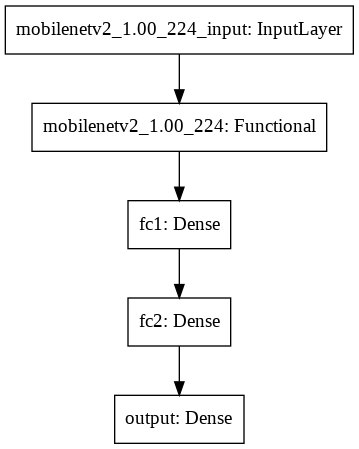

In [ ]:
# Tranfer learning model
model = tf.keras.models.Sequential([
  pretrained_model,

  tf.keras.layers.Dense(128, activation='leaky_relu', kernel_regularizer='l2', name='fc1'),
  tf.keras.layers.Dense(64, activation='leaky_relu', kernel_regularizer='l2', name='fc2'),

  tf.keras.layers.Dense(1, activation='sigmoid', name='output')
  ])


print(model.summary())
tf.keras.utils.plot_model(model)

# Model Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
18/18 [==============================] - 38s 342ms/step - loss: 3.0020 - accuracy: 0.9339 - val_loss: 2.5067 - val_accuracy: 0.9784
Epoch 2/100
18/18 [==============================] - 5s 256ms/step - loss: 2.0578 - accuracy: 0.9964 - val_loss: 1.7347 - val_accuracy: 0.9784
Epoch 3/100
18/18 [==============================] - 5s 255ms/step - loss: 1.3962 - accuracy: 1.0000 - val_loss: 1.2019 - val_accuracy: 0.9712
Epoch 4/100
18/18 [==============================] - 5s 250ms/step - loss: 0.9508 - accuracy: 1.0000 - val_loss: 0.8617 - val_accuracy: 0.9568
Epoch 5/100
18/18 [==============================] - 5s 250ms/step - loss: 0.6522 - accuracy: 1.0000 - val_loss: 0.6101 - val_accuracy: 0.9640
Epoch 6/100
18/18 [==============================] - 5s 250ms/step - loss: 0.4627 - accuracy: 1.0000 - val_loss: 0.4614 - val_accuracy: 0.9568
Epoch 7/100
18/18 [==============================] - 5s 253ms/step - loss: 0.3335 - accuracy: 1.0000 - val_loss: 0.3332 - val_accuracy: 0.971

# Model Evaluation

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.11287
Test Accuracy: 97.67%


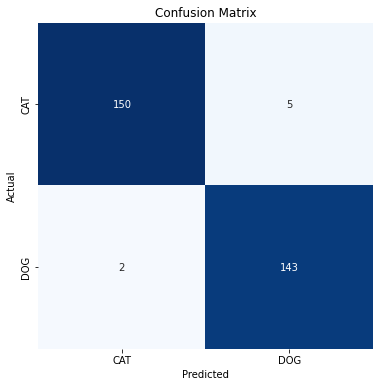

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.99      0.97      0.98       155
         DOG       0.97      0.99      0.98       145

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [ ]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# Save and Load Model

In [ ]:
model.save_weights('catdog_model', save_format='h5')

In [ ]:
model.load_weights('saved_model/')